In [1]:
!pip install morphsnakes
!pip install scipy

In [2]:
import warnings
warnings.filterwarnings("ignore")
!pip install --upgrade pandas==1.3.5

In [3]:
#load library
import numpy as np
import pandas as pd
import math
import cv2
import morphsnakes as ms
import matplotlib.pyplot as plt

In [4]:
#load wafer map data, check the data info
wafer_bins=pd.read_pickle("EdgeLocSelected.pkl")
wafer_bins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        154 non-null    object 
 1   dieSize         154 non-null    float64
 2   lotName         154 non-null    object 
 3   waferIndex      154 non-null    float64
 4   trianTestLabel  154 non-null    object 
 5   failureType     154 non-null    object 
dtypes: float64(2), object(4)
memory usage: 7.3+ KB


In [5]:
wafer=wafer_bins.copy()
wafer['failureNum']=wafer_bins.failureType
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8,'':9}
wafer=wafer.replace({'failureNum':mapping_type})

def find_shape(x):
    return x.shape

wafer['mapSize']=wafer.waferMap.apply(find_shape)

In [6]:
wafer.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureNum,mapSize
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]],2,"(53, 58)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]],2,"(53, 58)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]],2,"(53, 58)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]],2,"(53, 58)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,17.0,[[Training]],[[Edge-Loc]],2,"(53, 58)"


In [7]:
wafer.shape

(154, 8)

In [8]:
mymap=wafer.copy()

In [9]:
#erode snake method
fp=[]
weight=5

for i in range(0,mymap.shape[0]):
    # get the waferid
    waferid=mymap['lotName'][i]+":"+str(mymap['waferIndex'][i])

    # remove the wafer edge (null data)
    mam=mymap['waferMap'][i]
    mam_denoise=np.where(mam==1, 0, mam)
    
    # remove the single bit noise
    wafer_sample_denoise=mam_denoise.copy()
    (row, col)=mam_denoise.shape
    for i in range(1,row-1):
        for j in range (1,col-1):
            if mam_denoise[i,j]==2:
                if (mam_denoise[i-1:i+2,j-1:j+2].reshape((1,9))==2).sum()==1:
                    wafer_sample_denoise[i,j]=0
    # change the data type to float
    wafer_sample_denoise=wafer_sample_denoise/1.0
    
    # erode-dilate pre-processing iteration
    ite=1
    bulk  = cv2.erode(wafer_sample_denoise,  None, iterations=ite)
    bulk  = cv2.dilate(bulk,None, iterations=ite)

    # GAC Active Contour
    invg1     = ms.inverse_gaussian_gradient(bulk, alpha=1500, sigma=3.75)
    ls0      = ms.circle_level_set(bulk.shape, (int(bulk.shape[1]/2), int(bulk.shape[0]/2)), bulk.shape[1])
    lsf      = ms.morphological_geodesic_active_contour(invg1, 
                                                    iterations=40, 
                                                    init_level_set=ls0,
                                                    smoothing=1, 
                                                    threshold=0.5,
                                                    balloon=-1)

    # Fingerprint extraction
    rx=0
    ry=0
    idy=0
    idx=0
    max_x=-1
    max_y=-1
    max_len=0
    pixel_sum=0

    for a in lsf:
        pixel_sum=pixel_sum+a.sum()
        if a.sum()>rx:
            rx=a.sum()
        if a.sum()>0:
            ry=ry+1

        if max_len<len(np.flatnonzero(a!=0)):
            max_len=len(np.flatnonzero(a!=0))
            idx=int(np.flatnonzero(a!=0).mean())
            idy=max_y

        max_y=max_y+1
        max_x=max_x+1

    # Append the waferid, failure type, original map, GAC, area, radius, angle, quadrant_x, quadrant_y to fp array
    fp.append([waferid,mymap['failureNum'][i],
                   mam,
                   lsf,
                   (300/col*300/row*pixel_sum)*weight/(math.pi*150*150),
                   math.sqrt( pow(int(row-idy-row/2)*300/row,2) + pow(int(idx-col/2)*300/col,2) )/155,
                   np.arctan( (int(row-idy-row/2)*300/row) / (int(idx-col/2)*300/col+0.0001) ),
                   int(idx-col/2)/abs(int(idx-col/2)+0.0001),
                   int(row-idy-row/2)/abs(int(row-idy-row/2)+0.0001) ]
                   )


In [10]:
fp_pd=pd.DataFrame(fp,columns=[['waferid','failureNum','map','fp','area','radius','angle','quadrant_x','quadrant_y']])
fp_pd.head()

,waferid,failureNum,map,fp,area,radius,angle,quadrant_x,quadrant_y
0,lot2:12.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.051775,0.879841,0.166796,0.999996,0.999975
1,lot2:13.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.062129,0.894870,0.247368,0.999996,0.999983
2,lot2:14.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.151182,0.942353,0.483669,0.999996,0.999992
3,lot2:15.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.385203,0.849493,1.034825,0.999992,0.999995
4,lot2:17.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.327215,0.886552,1.419658,0.999975,0.999996


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
# Define the function to calculate Similarity Score
def get_similar_row(rows, target):
    return cosine_similarity(rows, [target])

In [12]:
#10,40,50,100
myi=30

# Target Wafer
target_waferid=fp_pd[['waferid']][myi:myi+1:].values[0]
target_map=fp_pd[['map']][myi:myi+1:]
target=fp_pd[['area','radius','angle','quadrant_x','quadrant_y']][myi:myi+1:].values[0]
print(target_waferid,target)

ref_waferid=fp_pd['waferid'][::].values
ref_other=fp_pd[['waferid','failureNum','map','fp','area','radius','angle','quadrant_x','quadrant_y']][::].values
ref=fp_pd[['area','radius','angle','quadrant_x','quadrant_y']][::].values
len(ref)

sim_score=get_similar_row(ref, target)
pd_score=pd.concat([pd.DataFrame(ref_other),pd.DataFrame(ref_waferid),pd.DataFrame(sim_score)],axis=1)
pd_score.columns=['waferid','failureNum','map','fp','area','radius','angle','quadrant_x','quadrant_y','waferid1','sim_score']

# Top 10 wafers with similar map
pd_score=pd_score.sort_values(by='sim_score', ascending=False).reset_index().head(10)
pd_score

['lot5917:23.0'] [ 0.16359132  0.7575321  -1.04888896  0.9999875  -1.00000526]


,index,waferid,failureNum,map,fp,area,radius,angle,quadrant_x,quadrant_y,waferid1,sim_score
0,30,lot5917:23.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.163591,0.757532,-1.048889,0.999988,-1.000005,lot5917:23.0,1.000000
1,24,lot5917:6.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.166364,0.757532,-1.048889,0.999988,-1.000005,lot5917:6.0,0.999999
2,22,lot5917:2.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.166364,0.757532,-1.048889,0.999988,-1.000005,lot5917:2.0,0.999999
3,26,lot5917:13.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.158046,0.757532,-1.048889,0.999988,-1.000005,lot5917:13.0,0.999996
4,23,lot5917:4.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.158046,0.757532,-1.048889,0.999988,-1.000005,lot5917:4.0,0.999996
5,25,lot5917:11.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.174682,0.757532,-1.048889,0.999988,-1.000005,lot5917:11.0,0.999984
6,37,lot6428:25.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.180228,0.757532,-1.048889,0.999988,-1.000005,lot6428:25.0,0.999963
7,28,lot5917:19.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.180228,0.757532,-1.048889,0.999988,-1.000005,lot5917:19.0,0.999963
8,32,lot6428:7.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.144182,0.757532,-1.048889,0.999988,-1.000005,lot6428:7.0,0.999949
9,33,lot6428:13.0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.144182,0.757532,-1.048889,0.999988,-1.000005,lot6428:13.0,0.999949


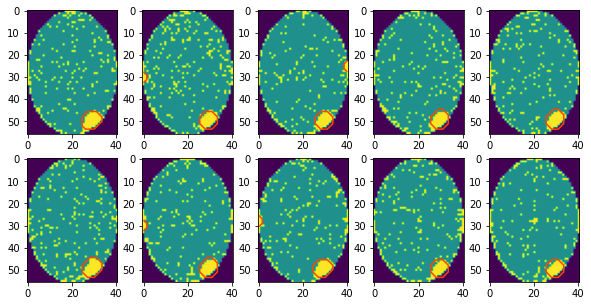

In [13]:
fig, axs = plt.subplots(2,5,figsize=(10,5))
for a in range(0,2):
    for b in range(0,5):
            axs[a,b].imshow(pd_score['map'][a*5+b])
            axs[a,b].contour(pd_score['fp'][a*5+b], [0.5], colors='orangered')

--Last Line--

In [16]:
fp1=[fp[0],fp[4],fp[7],fp[8],fp[20],fp[66],fp[120],fp[85]]

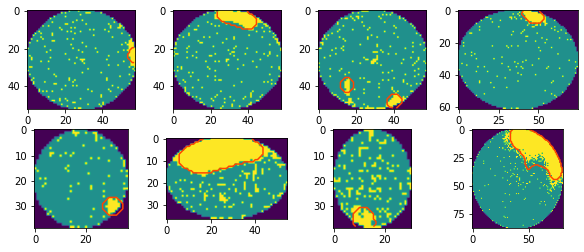

In [74]:
num=0
fig, axs = plt.subplots(2,4,figsize=(10,4))
for a in range(0,2):
    for b in range(0,4):
        if num<154:
            axs[a,b].imshow(fp1[a*4+b][2])
            axs[a,b].contour(fp1[a*4+b][3], [0.5], colors='orangered')
            num=num+1